In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import estimation_functions



In [60]:
np.random.seed(100)

In [61]:
df = pd.read_csv(f'../data/market_integrates_100.csv')
print(df)


     market_ids  firm_ids  characteristic1  characteristic2    prices  \
0             1         1         5.433865        20.042325  4.042316   
1             1         2         5.907737        20.412709  3.215516   
2             1         3         5.943911        20.174390  3.599365   
3             1         4         5.329441        20.844997  3.609258   
4             1         5         5.083033        20.137079  4.378925   
..          ...       ...              ...              ...       ...   
995         100         6         5.360283        20.580602  4.795188   
996         100         7         5.958183        20.650134  4.080402   
997         100         8         5.184745        20.346844  3.319145   
998         100         9         5.223118        20.464959  3.578026   
999         100        10         5.019838        20.675947  4.337036   

     marginal_cost    shares   profits   markups  e_quantity    capital  \
0         1.580903  0.023678  0.058281  2.556966

In [62]:
df2 = df.groupby('market_ids').sum('shares')
outside_good = np.repeat(np.array(df2.shares), 10)

# Get outside good same shape datagrame repeat each 10 times 
y = np.log(np.array(df.shares)) - np.log(outside_good)
print(y)


[-2.30791384 -2.29738004 -2.4164961  -2.31474342 -2.29418157 -2.43405035
 -2.41943464 -2.1973317  -2.18066272 -2.20344853 -2.28702848 -2.31308933
 -2.40121626 -2.27451398 -2.32977032 -2.45909445 -2.3916555  -2.22545515
 -2.14618888 -2.23710837 -2.30117332 -2.29687707 -2.44703557 -2.26306314
 -2.32412852 -2.44390356 -2.35123226 -2.23534968 -2.18131275 -2.21718264
 -2.28209441 -2.26696367 -2.41342865 -2.31507792 -2.31134816 -2.50460966
 -2.46035887 -2.147992   -2.1651378  -2.22243135 -2.26633598 -2.27206664
 -2.38437268 -2.34073624 -2.37359583 -2.52877694 -2.47353327 -2.14095928
 -2.19654928 -2.12955859 -2.22147525 -2.25937832 -2.37424947 -2.33566356
 -2.36156925 -2.57933624 -2.47885445 -2.17168536 -2.17179786 -2.15925166
 -2.21030738 -2.21462473 -2.53133129 -2.29017619 -2.34222748 -2.54031013
 -2.44975201 -2.20277098 -2.17462841 -2.16352122 -2.18397552 -2.20641087
 -2.56199372 -2.25329152 -2.30220509 -2.55059465 -2.45691401 -2.22492651
 -2.18316896 -2.20204543 -2.21021169 -2.18691834 -2

In [63]:
# Easy ols estimation 

x = df[['prices', 'characteristic1', 'characteristic2']]

res = LinearRegression().fit(x, y)

print('Intercept: \n', res.intercept_)
print('Coefficients: \n', res.coef_)



Intercept: 
 5.844292547697771
Coefficients: 
 [-0.30354179 -0.3727338  -0.248753  ]


In [64]:
# Frist stage regression some work 

x = df[['marginal_cost', 'characteristic1', 'characteristic2']]

res = LinearRegression().fit(x, df['prices'])

print('Intercept: \n', res.intercept_)
print('Coefficients: \n', res.coef_)

predictions_price = res.predict(x)
df['predict_prices'] = predictions_price


Intercept: 
 2.1108972801831785
Coefficients: 
 [ 1.63077371 -0.04269703 -0.01624029]


In [65]:
# Second stage: 

x = df[['predict_prices', 'characteristic1', 'characteristic2']]

res = LinearRegression().fit(x, y)

print('Intercept: \n', res.intercept_)
print('Coefficients: \n', res.coef_)



Intercept: 
 7.07818171038881
Coefficients: 
 [-0.37827311 -0.43859835 -0.27896539]


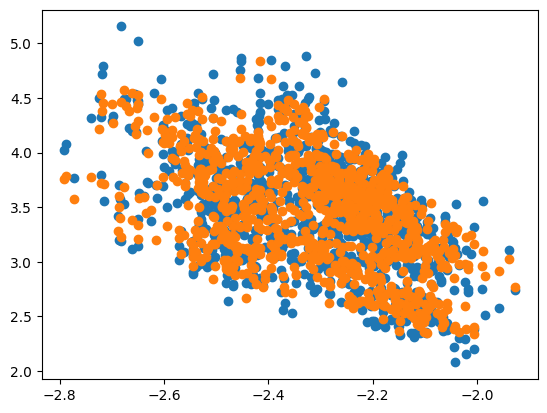

In [66]:

plt.scatter(y, df.prices)
plt.scatter(y, df.predict_prices)
plt.show()

In [67]:
# theta_0 = np.array([2, -0.5, 0.3, 0.05, 1.])
# theta_0 = np.array([2., -0.5, -0.3, 0.5, 1.])
# theta_0 = np.array([1.5, -1, -0.5, 0.5, 1.])
theta_0 = np.array([1., 1., 1., 1., 1.])





In [68]:
def f(theta, df, n_consumers, n_firms, T):
    # true_shares = np.array(df.shares)
    true_share = np.array(df.shares)
    all_est_shares = np.zeros(T*n_firms)
    v_p_all = np.random.normal(0, 1, n_consumers*T)
    for t in range(0, T-1):
        v_p = v_p_all[t*n_consumers:(t+1)*n_consumers]
        estimates_shares_market = estimation_functions.simulate_market_shares_per_period(theta, df, v_p, n_consumers, n_firms, t)
        all_est_shares[t*n_firms:(t+1)*n_firms] = estimates_shares_market
        mse = mean_squared_error(true_share, all_est_shares)
    return mse

In [69]:
N = 500 
firms  = 10
time = 100 

all_val_b0 = []
all_val_b1 = []
all_val_b2 = []
all_val_mu = []
all_val_omega = []

for l in range(1, 20):
    
    res = minimize(f, theta_0, args=(df, N, firms, time), method = 'Nelder-Mead')
    optim_vec = res.x

    all_val_b0.append(optim_vec[0])
    all_val_b1.append(optim_vec[1])
    all_val_b2.append(optim_vec[2])
    all_val_mu.append(optim_vec[3])
    all_val_omega.append(optim_vec[4])


df_estimation_values = pd.DataFrame({'beta_0': all_val_b0,
                                    'beta_1': all_val_b1,
                                    'beta_2': all_val_b2, 
                                    'mu': all_val_mu, 
                                    'omega': all_val_omega, 
                                    })
df_estimation_values.to_csv(f'../data/first_estimation_market_inter_100', index=False)


In [71]:
print(df_estimation_values)

      beta_0    beta_1    beta_2        mu     omega
0   1.990303 -0.953711 -0.195382  0.550850  1.240036
1   1.840610 -0.950646 -0.198481  0.551463  1.379072
2   1.969563 -0.970515 -0.189487  0.552009  1.234412
3   1.918189 -0.907028 -0.214824  0.536739  1.417652
4   1.991260 -0.953271 -0.195693  0.552412  1.237651
5   1.855042 -0.964511 -0.192356  0.548826  1.320275
6   1.974330 -0.970391 -0.190416  0.549313  1.234923
7   1.977963 -0.965580 -0.192182  0.548113  1.237400
8   1.981775 -0.966301 -0.191765  0.545739  1.237714
9   1.973572 -0.967242 -0.191508  0.550653  1.235583
10  1.857945 -0.961371 -0.192054  0.551174  1.320485
11  1.854487 -0.949404 -0.199090  0.551817  1.379657
12  2.568092 -0.404479 -0.403987  0.416390  1.941312
13  1.978941 -0.966556 -0.191570  0.548279  1.236537
14  3.073647 -0.478981 -0.383964  0.419457  1.293342
15  2.030051 -0.920662 -0.207541  0.546707  1.247309
16  1.854346 -0.968412 -0.191588  0.550864  1.316553
17  1.855333 -0.967825 -0.190412  0.548635  1.